This code currently does not work! It is here to document the attempted pipeline from pytorch>onnx>tensorflow

In [5]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
from torchvision.transforms import Resize
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets, transforms
from torch.autograd import Variable
import onnx
from onnx_tf.backend import prepare
import math

(29, 48)


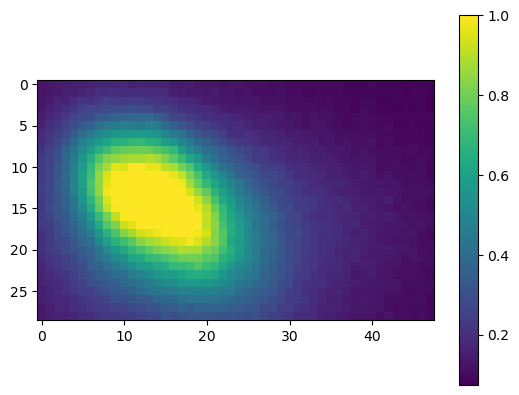

In [2]:

class HDF5Dataset(Dataset):
    def __init__(self, file_path, data_key):
        self.file_path = file_path
        self.data_key = data_key

        # Open the HDF5 file
        self.h5file = h5py.File(file_path, 'r')
        # Get the HDF5 dataset
        self.data = self.h5file[data_key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
       
        image = self.data[index]
        
        image=image/image.max()
    
      
        return image

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'



# Create an instance of the HDF5Dataset
dataset = HDF5Dataset(file_path, dataset_key)

# Create a data loader for the dataset
batch_size = 300
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



plt.imshow(dataset[0])
print(dataset[0].shape)
plt.colorbar()
plt.show()



In [35]:
class LeNet5(nn.Module):
     def __init__(self,func,num_classes, testing=False):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(48, 48)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(48, 24)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(24, num_classes)
        self.func = func
        self.testing=testing

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        embedding[:,4]=(math.pi/4)*(nn.Tanh()(embedding[:,4]) + 1)
        final=self.func(embedding)
        
        if self.testing==True:
            return out, embedding, final 
        
        return final

    


In [26]:
class GaussianGenerator(nn.Module):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        x = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)
        
        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)
        
        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))

        return img.unsqueeze(1)
    
    
img_dim = (29, 48)  # Replace with the desired image dimensions
model = GaussianGenerator(img_dim)
sample_params = torch.tensor([0.2, 0.2, 5.0, 5.0, 0.2], dtype=torch.float32)

# Reshape the sample_params tensor to have a batch dimension
sample_params_batched = sample_params.unsqueeze(0)
# Call the model to generate the Gaussian image
generated_img = model(sample_params_batched)


# Display the generated image shape
print("Generated Image Shape:", generated_img.shape)

Generated Image Shape: torch.Size([1, 1, 48, 29])


In [27]:
#TRAINING LOOP


net = LeNet5(GaussianGenerator((48,29)).float(),5).cuda().float() 
criterion = nn.MSELoss()

best_loss = float('inf')
best_model_path = 'best-model.pt'

num_epochs = 200
lr=1e-6



optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=1e-3, steps_per_epoch=len(data_loader))
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'
dataset = HDF5Dataset(file_path, dataset_key)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True,num_workers=0)



from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    

    for images in tqdm(data_loader):
        
        images = images.unsqueeze(1)

        optimizer.zero_grad()
        outputs = net(images.cuda())
        
        
        loss = criterion(outputs.float(), images.cuda().float())  # compare outputs with input images for reconstruction
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
    
    if average_loss < best_loss:
        best_loss = average_loss
        # Save the current model
        torch.save(net.state_dict(), best_model_path)





  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:01<00:00, 16.79it/s]


Epoch [1/200], Loss: 0.2340148521794213


100%|██████████| 27/27 [00:00<00:00, 99.32it/s]


Epoch [2/200], Loss: 0.2342846222497799


100%|██████████| 27/27 [00:00<00:00, 96.29it/s]


Epoch [3/200], Loss: 0.23418962569148452


100%|██████████| 27/27 [00:00<00:00, 100.01it/s]


Epoch [4/200], Loss: 0.23405287000868055


100%|██████████| 27/27 [00:00<00:00, 97.50it/s]


Epoch [5/200], Loss: 0.2340969697192863


100%|██████████| 27/27 [00:00<00:00, 94.37it/s]


Epoch [6/200], Loss: 0.234345735223205


100%|██████████| 27/27 [00:00<00:00, 100.18it/s]


Epoch [7/200], Loss: 0.23414308605370698


100%|██████████| 27/27 [00:00<00:00, 101.80it/s]


Epoch [8/200], Loss: 0.23429842293262482


100%|██████████| 27/27 [00:00<00:00, 103.42it/s]


Epoch [9/200], Loss: 0.23398469388484955


100%|██████████| 27/27 [00:00<00:00, 103.57it/s]


Epoch [10/200], Loss: 0.23398024174902174


100%|██████████| 27/27 [00:00<00:00, 103.46it/s]


Epoch [11/200], Loss: 0.23408958812554678


100%|██████████| 27/27 [00:00<00:00, 101.75it/s]


Epoch [12/200], Loss: 0.23406963050365448


100%|██████████| 27/27 [00:00<00:00, 100.97it/s]


Epoch [13/200], Loss: 0.23407527418048293


100%|██████████| 27/27 [00:00<00:00, 101.70it/s]


Epoch [14/200], Loss: 0.23418067506066076


100%|██████████| 27/27 [00:00<00:00, 103.42it/s]


Epoch [15/200], Loss: 0.2342251936594645


100%|██████████| 27/27 [00:00<00:00, 103.49it/s]


Epoch [16/200], Loss: 0.23394803868399727


100%|██████████| 27/27 [00:00<00:00, 102.91it/s]


Epoch [17/200], Loss: 0.2339829620387819


100%|██████████| 27/27 [00:00<00:00, 100.73it/s]


Epoch [18/200], Loss: 0.23409391553313644


100%|██████████| 27/27 [00:00<00:00, 100.42it/s]


Epoch [19/200], Loss: 0.2340264955052623


100%|██████████| 27/27 [00:00<00:00, 103.39it/s]


Epoch [20/200], Loss: 0.23417586088180542


100%|██████████| 27/27 [00:00<00:00, 101.65it/s]


Epoch [21/200], Loss: 0.23416200556136943


100%|██████████| 27/27 [00:00<00:00, 98.43it/s]


Epoch [22/200], Loss: 0.23411217055938863


100%|██████████| 27/27 [00:00<00:00, 102.05it/s]


Epoch [23/200], Loss: 0.23400766706025158


100%|██████████| 27/27 [00:00<00:00, 102.87it/s]


Epoch [24/200], Loss: 0.23415872896159137


100%|██████████| 27/27 [00:00<00:00, 102.14it/s]


Epoch [25/200], Loss: 0.23403335611025491


100%|██████████| 27/27 [00:00<00:00, 98.52it/s]


Epoch [26/200], Loss: 0.2339037193192376


100%|██████████| 27/27 [00:00<00:00, 98.63it/s]


Epoch [27/200], Loss: 0.23423724042044747


100%|██████████| 27/27 [00:00<00:00, 99.08it/s]


Epoch [28/200], Loss: 0.23418900977682183


100%|██████████| 27/27 [00:00<00:00, 94.17it/s]


Epoch [29/200], Loss: 0.23410713727827426


100%|██████████| 27/27 [00:00<00:00, 97.12it/s]


Epoch [30/200], Loss: 0.23419606575259455


100%|██████████| 27/27 [00:00<00:00, 99.72it/s]


Epoch [31/200], Loss: 0.23400043668570342


100%|██████████| 27/27 [00:00<00:00, 100.03it/s]


Epoch [32/200], Loss: 0.23412856845944016


100%|██████████| 27/27 [00:00<00:00, 97.70it/s]


Epoch [33/200], Loss: 0.2340821866635923


100%|██████████| 27/27 [00:00<00:00, 97.74it/s]


Epoch [34/200], Loss: 0.23403401728029605


100%|██████████| 27/27 [00:00<00:00, 96.94it/s]


Epoch [35/200], Loss: 0.23422682340498324


100%|██████████| 27/27 [00:00<00:00, 99.04it/s]


Epoch [36/200], Loss: 0.2342071599430508


100%|██████████| 27/27 [00:00<00:00, 98.03it/s]


Epoch [37/200], Loss: 0.23403865650848107


100%|██████████| 27/27 [00:00<00:00, 96.55it/s]


Epoch [38/200], Loss: 0.2340009460846583


100%|██████████| 27/27 [00:00<00:00, 98.46it/s]


Epoch [39/200], Loss: 0.2343066743126622


100%|██████████| 27/27 [00:00<00:00, 98.66it/s] 


Epoch [40/200], Loss: 0.23413570114859827


100%|██████████| 27/27 [00:00<00:00, 95.17it/s]


Epoch [41/200], Loss: 0.23398577173550925


100%|██████████| 27/27 [00:00<00:00, 95.48it/s]


Epoch [42/200], Loss: 0.2343541897005505


100%|██████████| 27/27 [00:00<00:00, 98.61it/s]


Epoch [43/200], Loss: 0.2340782450305091


100%|██████████| 27/27 [00:00<00:00, 98.68it/s]


Epoch [44/200], Loss: 0.23413951143070502


100%|██████████| 27/27 [00:00<00:00, 100.05it/s]


Epoch [45/200], Loss: 0.23414426214165157


100%|██████████| 27/27 [00:00<00:00, 99.99it/s]


Epoch [46/200], Loss: 0.23413515090942383


100%|██████████| 27/27 [00:00<00:00, 100.31it/s]


Epoch [47/200], Loss: 0.233882287034282


100%|██████████| 27/27 [00:00<00:00, 97.86it/s]


Epoch [48/200], Loss: 0.23417255889486382


100%|██████████| 27/27 [00:00<00:00, 100.07it/s]


Epoch [49/200], Loss: 0.2339937471681171


100%|██████████| 27/27 [00:00<00:00, 99.91it/s]


Epoch [50/200], Loss: 0.23404930807926036


100%|██████████| 27/27 [00:00<00:00, 100.03it/s]


Epoch [51/200], Loss: 0.2341334190633562


100%|██████████| 27/27 [00:00<00:00, 97.18it/s]


Epoch [52/200], Loss: 0.2342315415541331


100%|██████████| 27/27 [00:00<00:00, 100.99it/s]


Epoch [53/200], Loss: 0.2340583481170513


100%|██████████| 27/27 [00:00<00:00, 99.56it/s]


Epoch [54/200], Loss: 0.2341162970772496


100%|██████████| 27/27 [00:00<00:00, 97.44it/s]


Epoch [55/200], Loss: 0.23396444155110252


100%|██████████| 27/27 [00:00<00:00, 96.66it/s]


Epoch [56/200], Loss: 0.23411769723450696


100%|██████████| 27/27 [00:00<00:00, 100.17it/s]


Epoch [57/200], Loss: 0.23413294829704143


100%|██████████| 27/27 [00:00<00:00, 95.68it/s]


Epoch [58/200], Loss: 0.2343724607317536


100%|██████████| 27/27 [00:00<00:00, 99.38it/s]


Epoch [59/200], Loss: 0.2342334693228757


100%|██████████| 27/27 [00:00<00:00, 99.02it/s]


Epoch [60/200], Loss: 0.2341120778410523


100%|██████████| 27/27 [00:00<00:00, 99.79it/s]


Epoch [61/200], Loss: 0.23394411084828554


100%|██████████| 27/27 [00:00<00:00, 99.59it/s]


Epoch [62/200], Loss: 0.2340070621834861


100%|██████████| 27/27 [00:00<00:00, 97.16it/s]


Epoch [63/200], Loss: 0.23413402283633197


100%|██████████| 27/27 [00:00<00:00, 97.78it/s]


Epoch [64/200], Loss: 0.2342167435972779


100%|██████████| 27/27 [00:00<00:00, 97.16it/s]


Epoch [65/200], Loss: 0.23407716938742884


100%|██████████| 27/27 [00:00<00:00, 100.18it/s]


Epoch [66/200], Loss: 0.2340161618259218


100%|██████████| 27/27 [00:00<00:00, 100.07it/s]


Epoch [67/200], Loss: 0.23408020591294323


100%|██████████| 27/27 [00:00<00:00, 97.10it/s]


Epoch [68/200], Loss: 0.23427731902511031


100%|██████████| 27/27 [00:00<00:00, 100.25it/s]


Epoch [69/200], Loss: 0.23396259822227336


100%|██████████| 27/27 [00:00<00:00, 100.97it/s]


Epoch [70/200], Loss: 0.23420053058200413


100%|██████████| 27/27 [00:00<00:00, 98.77it/s]


Epoch [71/200], Loss: 0.2342277748717202


100%|██████████| 27/27 [00:00<00:00, 99.79it/s]


Epoch [72/200], Loss: 0.23421260880099404


100%|██████████| 27/27 [00:00<00:00, 100.35it/s]


Epoch [73/200], Loss: 0.234320514731937


100%|██████████| 27/27 [00:00<00:00, 101.05it/s]


Epoch [74/200], Loss: 0.2342142821462066


100%|██████████| 27/27 [00:00<00:00, 98.10it/s]


Epoch [75/200], Loss: 0.23387997625050722


100%|██████████| 27/27 [00:00<00:00, 101.01it/s]


Epoch [76/200], Loss: 0.23407951494057974


100%|██████████| 27/27 [00:00<00:00, 99.65it/s]


Epoch [77/200], Loss: 0.2340338141829879


100%|██████████| 27/27 [00:00<00:00, 100.78it/s]


Epoch [78/200], Loss: 0.2340605799798612


100%|██████████| 27/27 [00:00<00:00, 99.87it/s]


Epoch [79/200], Loss: 0.23409848853393836


100%|██████████| 27/27 [00:00<00:00, 97.88it/s]


Epoch [80/200], Loss: 0.23402750933611835


100%|██████████| 27/27 [00:00<00:00, 97.25it/s]


Epoch [81/200], Loss: 0.23401056230068207


100%|██████████| 27/27 [00:00<00:00, 100.83it/s]


Epoch [82/200], Loss: 0.2340312589097906


100%|██████████| 27/27 [00:00<00:00, 100.37it/s]


Epoch [83/200], Loss: 0.23394613023157473


100%|██████████| 27/27 [00:00<00:00, 96.33it/s]


Epoch [84/200], Loss: 0.23412290270681735


100%|██████████| 27/27 [00:00<00:00, 96.19it/s]


Epoch [85/200], Loss: 0.23419585879202243


100%|██████████| 27/27 [00:00<00:00, 99.07it/s]


Epoch [86/200], Loss: 0.23399786375187062


100%|██████████| 27/27 [00:00<00:00, 100.19it/s]


Epoch [87/200], Loss: 0.23405672664995547


100%|██████████| 27/27 [00:00<00:00, 95.47it/s]


Epoch [88/200], Loss: 0.2340437924420392


100%|██████████| 27/27 [00:00<00:00, 97.30it/s]


Epoch [89/200], Loss: 0.2341974797072234


100%|██████████| 27/27 [00:00<00:00, 96.21it/s]


Epoch [90/200], Loss: 0.2342017822795444


100%|██████████| 27/27 [00:00<00:00, 99.17it/s]


Epoch [91/200], Loss: 0.23394245516370843


100%|██████████| 27/27 [00:00<00:00, 99.11it/s]


Epoch [92/200], Loss: 0.23408352224915116


100%|██████████| 27/27 [00:00<00:00, 97.27it/s]


Epoch [93/200], Loss: 0.23403152216363837


100%|██████████| 27/27 [00:00<00:00, 100.03it/s]


Epoch [94/200], Loss: 0.2341860411343751


100%|██████████| 27/27 [00:00<00:00, 99.06it/s]


Epoch [95/200], Loss: 0.2341822396825861


100%|██████████| 27/27 [00:00<00:00, 99.71it/s]


Epoch [96/200], Loss: 0.23409129237687146


100%|██████████| 27/27 [00:00<00:00, 97.50it/s]


Epoch [97/200], Loss: 0.2340390588398333


100%|██████████| 27/27 [00:00<00:00, 94.92it/s]


Epoch [98/200], Loss: 0.23385248029673542


100%|██████████| 27/27 [00:00<00:00, 96.49it/s]


Epoch [99/200], Loss: 0.23408955390806552


100%|██████████| 27/27 [00:00<00:00, 98.94it/s]


Epoch [100/200], Loss: 0.23388964544843743


100%|██████████| 27/27 [00:00<00:00, 100.13it/s]


Epoch [101/200], Loss: 0.23408302664756775


100%|██████████| 27/27 [00:00<00:00, 98.02it/s]


Epoch [102/200], Loss: 0.23405727357776077


100%|██████████| 27/27 [00:00<00:00, 96.79it/s]


Epoch [103/200], Loss: 0.2340909226073159


100%|██████████| 27/27 [00:00<00:00, 99.25it/s]


Epoch [104/200], Loss: 0.23424359438595949


100%|██████████| 27/27 [00:00<00:00, 97.26it/s]


Epoch [105/200], Loss: 0.23427752432999788


100%|██████████| 27/27 [00:00<00:00, 95.48it/s]


Epoch [106/200], Loss: 0.23395986799840574


100%|██████████| 27/27 [00:00<00:00, 97.74it/s]


Epoch [107/200], Loss: 0.23406214460178656


100%|██████████| 27/27 [00:00<00:00, 99.58it/s]


Epoch [108/200], Loss: 0.23383844229910108


100%|██████████| 27/27 [00:00<00:00, 99.27it/s]


Epoch [109/200], Loss: 0.23430315763862045


100%|██████████| 27/27 [00:00<00:00, 97.32it/s]


Epoch [110/200], Loss: 0.23397685477027186


100%|██████████| 27/27 [00:00<00:00, 100.87it/s]


Epoch [111/200], Loss: 0.23408905720269238


100%|██████████| 27/27 [00:00<00:00, 101.33it/s]


Epoch [112/200], Loss: 0.23429333832528856


100%|██████████| 27/27 [00:00<00:00, 102.35it/s]


Epoch [113/200], Loss: 0.23405086442276282


100%|██████████| 27/27 [00:00<00:00, 103.19it/s]


Epoch [114/200], Loss: 0.234109780854649


100%|██████████| 27/27 [00:00<00:00, 103.81it/s]


Epoch [115/200], Loss: 0.23404983072369187


100%|██████████| 27/27 [00:00<00:00, 102.79it/s]


Epoch [116/200], Loss: 0.23416881208066587


100%|██████████| 27/27 [00:00<00:00, 100.12it/s]


Epoch [117/200], Loss: 0.23407505894148792


100%|██████████| 27/27 [00:00<00:00, 100.52it/s]


Epoch [118/200], Loss: 0.23428600585019146


100%|██████████| 27/27 [00:00<00:00, 98.81it/s]


Epoch [119/200], Loss: 0.2339921102479652


100%|██████████| 27/27 [00:00<00:00, 99.85it/s]


Epoch [120/200], Loss: 0.2341667424749445


100%|██████████| 27/27 [00:00<00:00, 100.95it/s]


Epoch [121/200], Loss: 0.23409911493460336


100%|██████████| 27/27 [00:00<00:00, 99.81it/s]


Epoch [122/200], Loss: 0.23397887029029704


100%|██████████| 27/27 [00:00<00:00, 100.54it/s]


Epoch [123/200], Loss: 0.23434526280120568


100%|██████████| 27/27 [00:00<00:00, 99.59it/s]


Epoch [124/200], Loss: 0.23408856380868842


100%|██████████| 27/27 [00:00<00:00, 102.13it/s]


Epoch [125/200], Loss: 0.23406741243821602


100%|██████████| 27/27 [00:00<00:00, 101.12it/s]


Epoch [126/200], Loss: 0.17152350809839037


100%|██████████| 27/27 [00:00<00:00, 100.10it/s]


Epoch [127/200], Loss: 0.041626189869863016


100%|██████████| 27/27 [00:00<00:00, 97.48it/s]


Epoch [128/200], Loss: 0.01685193232778046


100%|██████████| 27/27 [00:00<00:00, 99.10it/s]


Epoch [129/200], Loss: 0.012506399062220697


100%|██████████| 27/27 [00:00<00:00, 100.67it/s]


Epoch [130/200], Loss: 0.010836551793747477


100%|██████████| 27/27 [00:00<00:00, 99.76it/s]


Epoch [131/200], Loss: 0.010317196379657145


100%|██████████| 27/27 [00:00<00:00, 100.49it/s]


Epoch [132/200], Loss: 0.010172514658835199


100%|██████████| 27/27 [00:00<00:00, 100.58it/s]


Epoch [133/200], Loss: 0.010165412461868039


100%|██████████| 27/27 [00:00<00:00, 100.56it/s]


Epoch [134/200], Loss: 0.01014801539066765


100%|██████████| 27/27 [00:00<00:00, 102.22it/s]


Epoch [135/200], Loss: 0.0100851288686196


100%|██████████| 27/27 [00:00<00:00, 103.98it/s]


Epoch [136/200], Loss: 0.010018285260432296


100%|██████████| 27/27 [00:00<00:00, 104.00it/s]


Epoch [137/200], Loss: 0.010035110741025872


100%|██████████| 27/27 [00:00<00:00, 102.60it/s]


Epoch [138/200], Loss: 0.01006798218521807


100%|██████████| 27/27 [00:00<00:00, 100.32it/s]


Epoch [139/200], Loss: 0.009907041296914772


100%|██████████| 27/27 [00:00<00:00, 100.83it/s]


Epoch [140/200], Loss: 0.009837891837513005


100%|██████████| 27/27 [00:00<00:00, 99.92it/s] 


Epoch [141/200], Loss: 0.009771479466171176


100%|██████████| 27/27 [00:00<00:00, 100.30it/s]


Epoch [142/200], Loss: 0.009689612383091892


100%|██████████| 27/27 [00:00<00:00, 99.67it/s]


Epoch [143/200], Loss: 0.009650228993484267


100%|██████████| 27/27 [00:00<00:00, 100.54it/s]


Epoch [144/200], Loss: 0.00954017132796623


100%|██████████| 27/27 [00:00<00:00, 99.85it/s]


Epoch [145/200], Loss: 0.009530524033363219


100%|██████████| 27/27 [00:00<00:00, 100.28it/s]


Epoch [146/200], Loss: 0.0094932045235678


100%|██████████| 27/27 [00:00<00:00, 99.74it/s]


Epoch [147/200], Loss: 0.009536822705909057


100%|██████████| 27/27 [00:00<00:00, 98.51it/s]


Epoch [148/200], Loss: 0.009517397076167443


100%|██████████| 27/27 [00:00<00:00, 99.15it/s]


Epoch [149/200], Loss: 0.009495642760561572


100%|██████████| 27/27 [00:00<00:00, 100.60it/s]


Epoch [150/200], Loss: 0.009476771509205853


100%|██████████| 27/27 [00:00<00:00, 100.58it/s]


Epoch [151/200], Loss: 0.009480519427193536


100%|██████████| 27/27 [00:00<00:00, 100.19it/s]


Epoch [152/200], Loss: 0.009452408766029057


100%|██████████| 27/27 [00:00<00:00, 101.01it/s]


Epoch [153/200], Loss: 0.009473678448961841


100%|██████████| 27/27 [00:00<00:00, 97.99it/s]


Epoch [154/200], Loss: 0.009463895112276077


100%|██████████| 27/27 [00:00<00:00, 97.24it/s]


Epoch [155/200], Loss: 0.009495137500818129


100%|██████████| 27/27 [00:00<00:00, 97.22it/s]


Epoch [156/200], Loss: 0.009472315165179747


100%|██████████| 27/27 [00:00<00:00, 97.87it/s]


Epoch [157/200], Loss: 0.009467201272922533


100%|██████████| 27/27 [00:00<00:00, 98.38it/s]


Epoch [158/200], Loss: 0.009464155537662682


100%|██████████| 27/27 [00:00<00:00, 103.19it/s]


Epoch [159/200], Loss: 0.009467657896931525


100%|██████████| 27/27 [00:00<00:00, 103.83it/s]


Epoch [160/200], Loss: 0.009487825204376821


100%|██████████| 27/27 [00:00<00:00, 103.13it/s]


Epoch [161/200], Loss: 0.009498329936630197


100%|██████████| 27/27 [00:00<00:00, 100.74it/s]


Epoch [162/200], Loss: 0.009479264970178957


100%|██████████| 27/27 [00:00<00:00, 103.85it/s]


Epoch [163/200], Loss: 0.009449465131318127


100%|██████████| 27/27 [00:00<00:00, 103.79it/s]


Epoch [164/200], Loss: 0.00946714635938406


100%|██████████| 27/27 [00:00<00:00, 103.97it/s]


Epoch [165/200], Loss: 0.009441562583325085


100%|██████████| 27/27 [00:00<00:00, 103.89it/s]


Epoch [166/200], Loss: 0.00946329099436601


100%|██████████| 27/27 [00:00<00:00, 101.06it/s]


Epoch [167/200], Loss: 0.009452602377644292


100%|██████████| 27/27 [00:00<00:00, 103.70it/s]


Epoch [168/200], Loss: 0.009456146129027562


100%|██████████| 27/27 [00:00<00:00, 103.79it/s]


Epoch [169/200], Loss: 0.009478145554937699


100%|██████████| 27/27 [00:00<00:00, 101.18it/s]


Epoch [170/200], Loss: 0.009455621311510051


100%|██████████| 27/27 [00:00<00:00, 101.08it/s]


Epoch [171/200], Loss: 0.009471655409369204


100%|██████████| 27/27 [00:00<00:00, 101.36it/s]


Epoch [172/200], Loss: 0.009439030903632994


100%|██████████| 27/27 [00:00<00:00, 100.28it/s]


Epoch [173/200], Loss: 0.00946078245976457


100%|██████████| 27/27 [00:00<00:00, 101.02it/s]


Epoch [174/200], Loss: 0.00943799292737687


100%|██████████| 27/27 [00:00<00:00, 101.18it/s]


Epoch [175/200], Loss: 0.009470263909962442


100%|██████████| 27/27 [00:00<00:00, 101.77it/s]


Epoch [176/200], Loss: 0.009464478775582931


100%|██████████| 27/27 [00:00<00:00, 103.86it/s]


Epoch [177/200], Loss: 0.009449634183612134


100%|██████████| 27/27 [00:00<00:00, 104.02it/s]


Epoch [178/200], Loss: 0.009433909181367469


100%|██████████| 27/27 [00:00<00:00, 103.30it/s]


Epoch [179/200], Loss: 0.009452707582601794


100%|██████████| 27/27 [00:00<00:00, 101.12it/s]


Epoch [180/200], Loss: 0.009430340939649829


100%|██████████| 27/27 [00:00<00:00, 101.09it/s]


Epoch [181/200], Loss: 0.009431393472132859


100%|██████████| 27/27 [00:00<00:00, 101.16it/s]


Epoch [182/200], Loss: 0.009416573336003002


100%|██████████| 27/27 [00:00<00:00, 101.93it/s]


Epoch [183/200], Loss: 0.00942991135848893


100%|██████████| 27/27 [00:00<00:00, 103.92it/s]


Epoch [184/200], Loss: 0.009428351876084451


100%|██████████| 27/27 [00:00<00:00, 103.95it/s]


Epoch [185/200], Loss: 0.009435689490702417


100%|██████████| 27/27 [00:00<00:00, 103.74it/s]


Epoch [186/200], Loss: 0.009445064528672784


100%|██████████| 27/27 [00:00<00:00, 103.81it/s]


Epoch [187/200], Loss: 0.00942466263141897


100%|██████████| 27/27 [00:00<00:00, 103.95it/s]


Epoch [188/200], Loss: 0.009421591405515317


100%|██████████| 27/27 [00:00<00:00, 101.34it/s]


Epoch [189/200], Loss: 0.009429462185060536


100%|██████████| 27/27 [00:00<00:00, 99.30it/s]


Epoch [190/200], Loss: 0.009427735616487486


100%|██████████| 27/27 [00:00<00:00, 100.64it/s]


Epoch [191/200], Loss: 0.00943584233108494


100%|██████████| 27/27 [00:00<00:00, 100.00it/s]


Epoch [192/200], Loss: 0.009430455112898792


100%|██████████| 27/27 [00:00<00:00, 99.04it/s]


Epoch [193/200], Loss: 0.009413540156351196


100%|██████████| 27/27 [00:00<00:00, 97.93it/s]


Epoch [194/200], Loss: 0.009427037193543382


100%|██████████| 27/27 [00:00<00:00, 100.33it/s]


Epoch [195/200], Loss: 0.009424659389036673


100%|██████████| 27/27 [00:00<00:00, 100.60it/s]


Epoch [196/200], Loss: 0.009433082373881782


100%|██████████| 27/27 [00:00<00:00, 100.37it/s]


Epoch [197/200], Loss: 0.009411826626294188


100%|██████████| 27/27 [00:00<00:00, 99.56it/s]


Epoch [198/200], Loss: 0.009448755635983415


100%|██████████| 27/27 [00:00<00:00, 97.98it/s]


Epoch [199/200], Loss: 0.009419215084226043


100%|██████████| 27/27 [00:00<00:00, 97.77it/s]

Epoch [200/200], Loss: 0.009431562903854582


In [28]:
with torch.no_grad():
  dev=torch.device("cuda")
  data = next(iter(data_loader))
  data=data.unsqueeze(1)
  data_ = data.cpu()
  optimizer.zero_grad()
  outputs = net(data.to('cuda')).cpu()
  

In [29]:
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
manual_im=[]
with h5py.File(path, 'r') as h5:
    for i in range(100):
        manual_im.append(h5['growth_1']['spot_2']['reconstructed_image'][i])
    

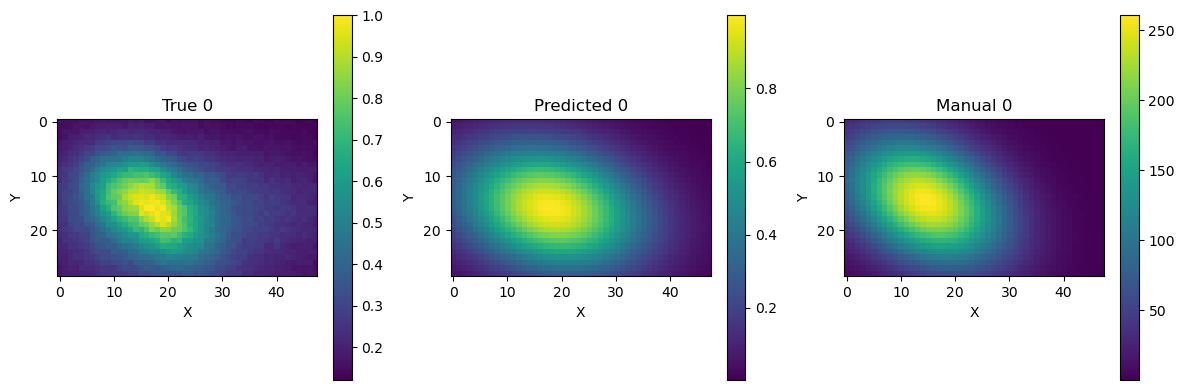

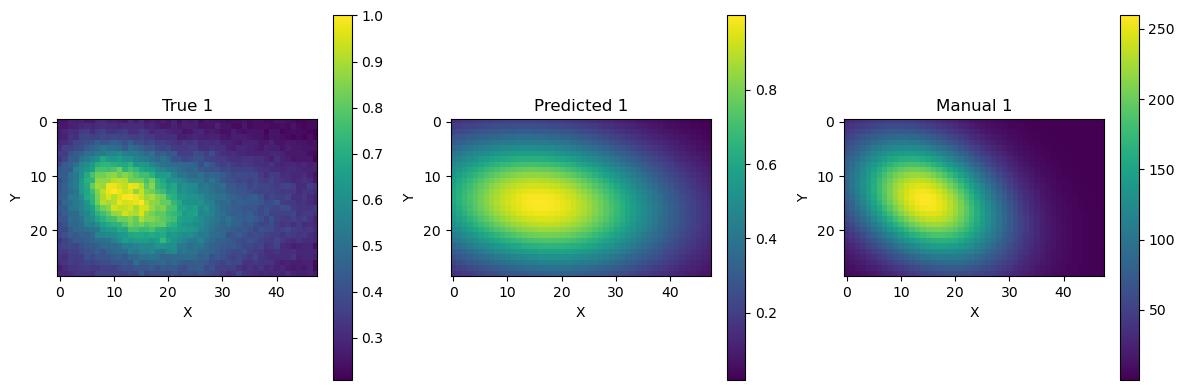

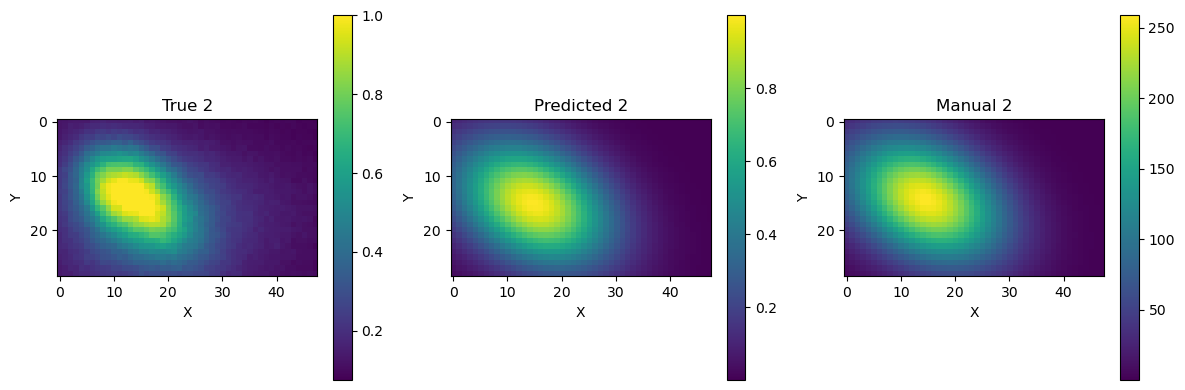

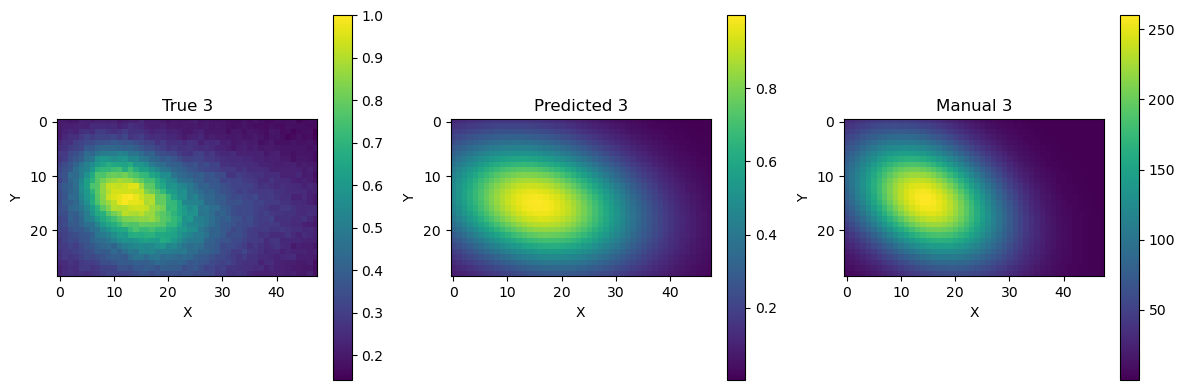

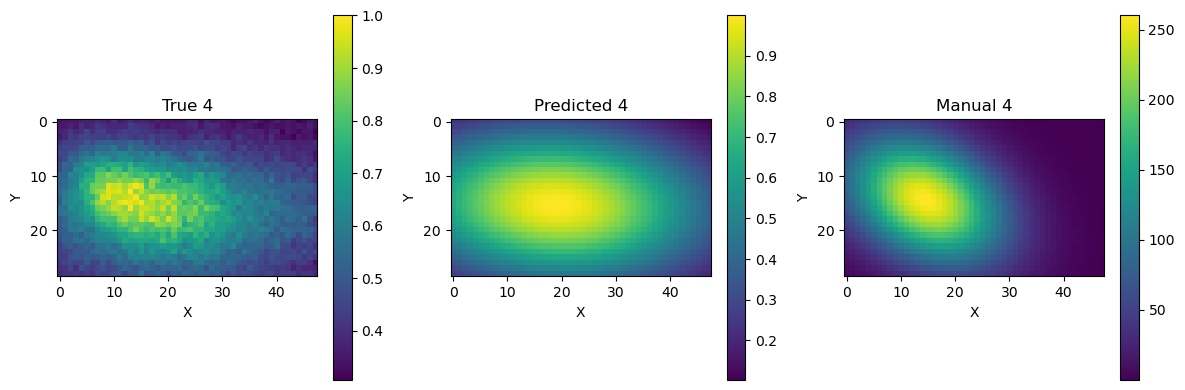

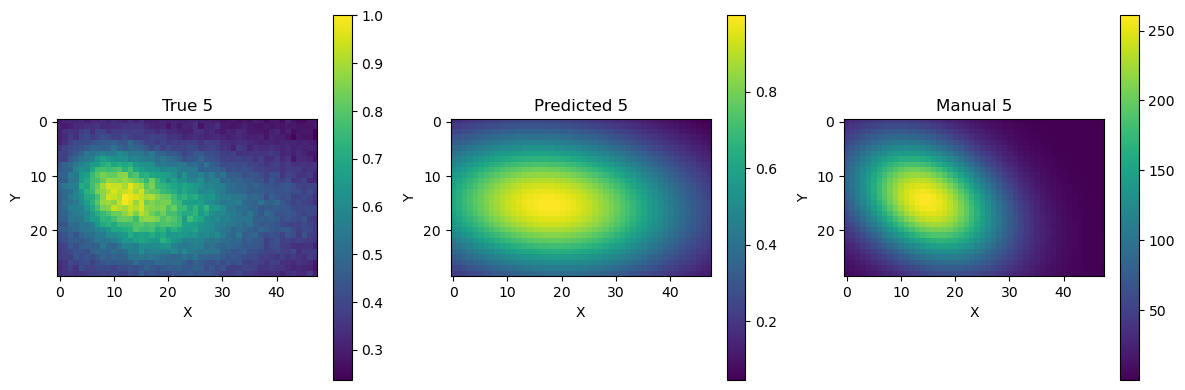

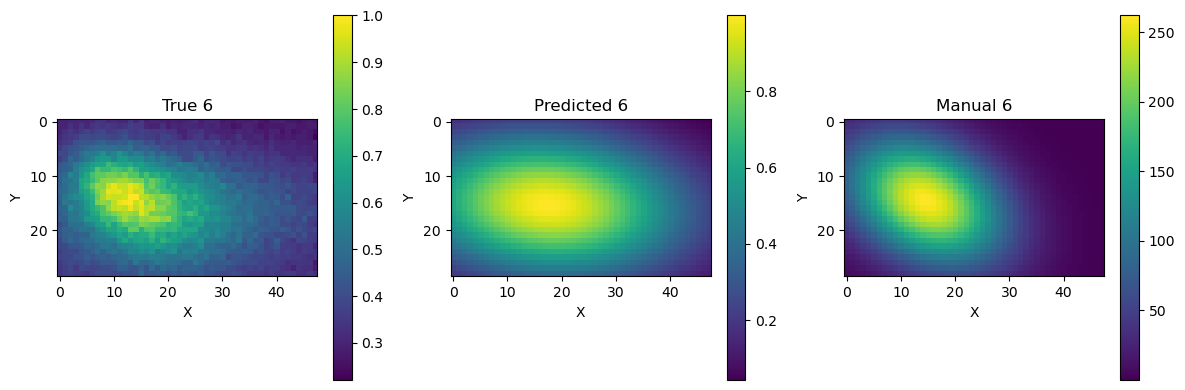

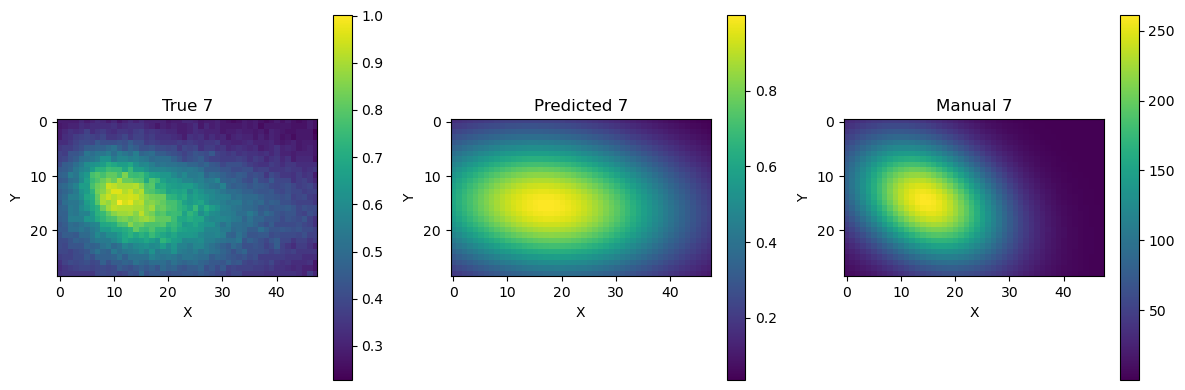

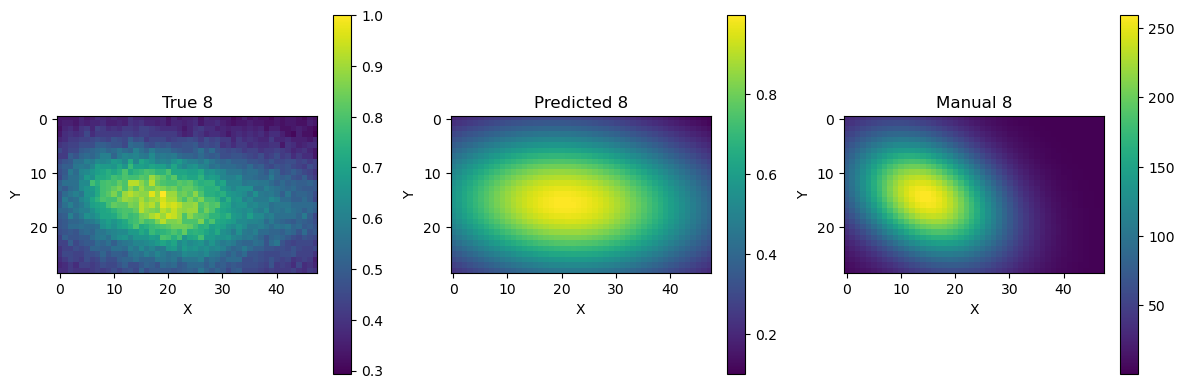

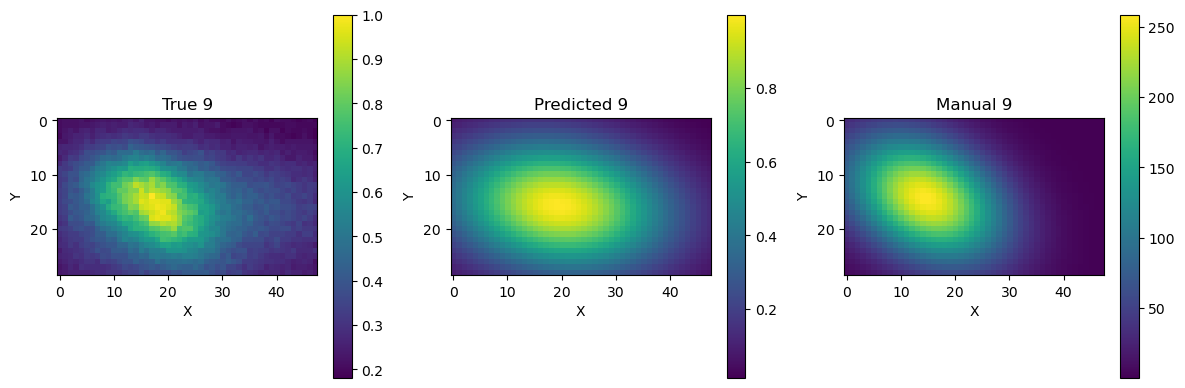

In [30]:

import matplotlib.pyplot as plt

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot true image
    im0 = axs[0].imshow(data[i,0])
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0])

    # Plot predicted image
    im1 = axs[1].imshow(outputs[i, 0].detach().cpu().numpy().squeeze())
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1])

    # Plot manual(average) image
    im2 = axs[2].imshow(manual_im[i])
    axs[2].set_title(f'Manual {i}')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    fig.colorbar(im2, ax=axs[2])

    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'OutputData/images_{i}.png')

    # Display the figure
    plt.show()



In [ ]:
torch.save(net.state_dict(), 'PytorchLeNet3.pt')
#Saves the most recent model

In [16]:
#Model analyzer

model = LeNet5(GaussianGenerator((48,29)).float(),5)  # Replace num_classes with the appropriate number for your task

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}, Parameters: {param.numel()}")

Total number of parameters: 6269
Layer: layer1.0.weight, Shape: torch.Size([6, 1, 5, 5]), Parameters: 150
Layer: layer1.0.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.weight, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer2.0.weight, Shape: torch.Size([16, 6, 5, 5]), Parameters: 2400
Layer: layer2.0.bias, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.weight, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.bias, Shape: torch.Size([16]), Parameters: 16
Layer: fc.weight, Shape: torch.Size([48, 48]), Parameters: 2304
Layer: fc.bias, Shape: torch.Size([48]), Parameters: 48
Layer: fc1.weight, Shape: torch.Size([24, 48]), Parameters: 1152
Layer: fc1.bias, Shape: torch.Size([24]), Parameters: 24
Layer: fc2.weight, Shape: torch.Size([5, 24]), Parameters: 120
Layer: fc2.bias, Shape: torch.Size([5]), Parameters: 5


In [25]:
#export with dummy input
net = LeNet5_inference(5).cuda()


net.load_state_dict(torch.load('PytorchLeNet.pt'))
dummy_input = Variable(torch.randn(1, 1, 29, 48)).cuda()
print(dummy_input.shape)
torch.onnx.export(net, dummy_input, "LeNet5_nofunc.onnx")

torch.Size([1, 1, 29, 48])
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [41]:
#export with real data

import h5py
import numpy as np

net = LeNet5_inference(5).cuda()
net.load_state_dict(torch.load('PytorchLeNet2.pt'))


path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    data = h5['growth_1']['spot_2']['raw_image'][1]

# Reshape the data to (1, 1, 29, 48)
data = data.reshape((1, 1, 29, 48))
data= torch.tensor(np.float32(data)).cuda()
print(data.dtype)

torch.onnx.export(net, data, "LeNet5_nofunc3.onnx",input_names=['input_1'], output_names=['output_1'])

torch.float32
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [42]:
 #onnx conversion
 model = onnx.load('LeNet5_nofunc2.onnx')
 tf_rep = prepare(model) 
 

2023-08-07 12:34:24.823273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-07 12:34:24.823495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-07 12:34:24.824161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [47]:
#attempted onnx>tensorflow conversion
from onnx2keras import onnx_to_keras

# Load ONNX model
onnx_model = onnx.load('LeNet5_nofunc2.onnx')


path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_1']['spot_2']['raw_image'][1]
print(img.shape)
img=img/img.max()
print((np.asarray(img, dtype=np.float32)[np.newaxis, np.newaxis, :, :]).shape)

# Call the converter (input - is the main model input name, can be different for your model)
k_model = onnx_to_keras(onnx_model, ['input_1'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_1.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_1.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (48, 48).
DEBUG:onnx2keras:Found weight fc.bias with shape (48,).
DEBUG:onnx2keras:Found weight fc1.weight with shape (24, 48).
DEBUG:onnx2keras:Found weight fc1.bias with shape (24,).
DEBUG:onnx2keras:Found weight fc2.weight with shape (5, 24).
DEBUG:onnx2keras:Found weight fc2.bias with shape (5,).
DEBUG:onnx2keras:Found weight onnx::Conv_43 with shape (6, 1, 5, 5).
DEBUG:onnx2keras:Found weight onnx::Conv_44 with shape (6,).
DEBUG:onnx2keras:Found weight onnx::Conv_46 with shape (16, 6, 5, 5).
DEBUG:onnx2keras:Found weight onnx::Conv_47 with shape (16,).
DEBUG:onnx2keras:Found input input_1 with shape [1, 29, 48]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:..

(29, 48)
(1, 1, 29, 48)


ValueError: '/layer1/layer1.0/Conv_output_0/' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$

In [44]:
#running in tensorflow using the onnx model
import numpy as np
from IPython.display import display
from PIL import Image

print('Image 1:')
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_1']['spot_2']['raw_image'][1]
print(img.shape)
img=img/img.max()
print((np.asarray(img, dtype=np.float32)[np.newaxis, np.newaxis, :, :]).shape)
output = tf_rep.run(np.asarray(img, dtype=np.float32)[np.newaxis, np.newaxis, :, :])
print(output)




Image 1:
(29, 48)
(1, 1, 29, 48)
Outputs(output_1=array([[15.067148 , 14.822563 , 10.844122 ,  7.341039 ,  1.0778029]],
      dtype=float32))


2023-08-07 12:34:39.852833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-07 12:34:39.926482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [21]:
print(output[0].dtype)

float32


In [87]:
tf_rep.export_graph('TFLeNet5.h5')
#this prints to a file, but the h5 file is the wrong format for hls4ml

INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_11_x in the SavedModel.


INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: TFLeNet5.h5/assets


INFO:tensorflow:Assets written to: TFLeNet5.h5/assets
INFO:absl:Writing fingerprint to TFLeNet5.h5/fingerprint.pb


In [1]:
import hls4ml

2023-08-03 15:16:47.193468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 15:16:47.686896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
config=tf.saved_model.load('LeNet5TF.pb')

hls_model = hls4ml.converters.keras_to_hls(config)
hls4ml.utils.fetch_example_list()

2023-08-03 15:19:29.971705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 15:19:29.971921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 15:19:29.972621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

TypeError: argument of type '_UserObject' is not iterable

In [82]:
import tensorflow as tf

modelTF=tf.keras.models.load_model('LeNet5TF.pb')

path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_1']['spot_2']['raw_image'][1]
    img= img/img.max()
imgTF = np.asarray(img, dtype=np.float32)[np.newaxis, :, :, np.newaxis]
print(imgTF.shape)


prediction=modelTF(imgTF)

print(prediction)

(1, 29, 48, 1)


TypeError: Binding inputs to tf.function `f` failed due to `too many positional arguments`. Received args: (array([[[[0.11764706],
         [0.12941177],
         [0.13725491],
         ...,
         [0.08627451],
         [0.09019608],
         [0.08627451]],

        [[0.12941177],
         [0.12941177],
         [0.14509805],
         ...,
         [0.08235294],
         [0.08627451],
         [0.09019608]],

        [[0.12941177],
         [0.14901961],
         [0.16862746],
         ...,
         [0.08627451],
         [0.08627451],
         [0.07450981]],

        ...,

        [[0.16078432],
         [0.16862746],
         [0.18039216],
         ...,
         [0.10588235],
         [0.10588235],
         [0.08627451]],

        [[0.14117648],
         [0.16470589],
         [0.18039216],
         ...,
         [0.10588235],
         [0.09803922],
         [0.09019608]],

        [[0.14117648],
         [0.16470589],
         [0.16078432],
         ...,
         [0.10588235],
         [0.11372549],
         [0.09803922]]]], dtype=float32),) and kwargs: {} for signature: (**kwargs).